In [410]:
from fuel_model import total_fuel_consumption
import pickle
import numpy as np
from deap import base, creator, tools, algorithms
import matplotlib.pyplot as plt
import time
import random

SEED = 42  # SEED for reproducibility
random.seed(SEED)
np.random.seed(SEED)

In [411]:
# Open merged dataset of speed and volume
# with open('datasets/df_merged.pkl', 'rb') as f:
#     df_merged = pickle.load(f)  
# df_merged 


In [412]:
# Open aggregated dataset of speed and volume
with open('datasets/df_aggregated.pkl', 'rb') as f:
    df_aggregated = pickle.load(f)  
df_aggregated

,Roadway Name,Segment Length,Volume,Borough,Speed,Fuel Consumption
0,120 AVENUE,80.4,290273.0,Queens,41.486279,11866272
1,126 STREET,80.4,252902.0,Manhattan,16.289045,7897157
2,31 AVENUE,80.4,280905.0,Queens,41.486279,11505216
3,MAIN STREET,80.4,383042.0,Queens,41.486279,15695532
4,SANFORD AVE,160.8,306435.0,Queens,41.486279,25057920


In [413]:
NUM_SEGMENTS = 5  # Number of road segments

# Signal timing constraints (in seconds)
MIN_GREEN, MAX_GREEN = 10, 120
MIN_YELLOW, MAX_YELLOW = 3, 8
MIN_RED, MAX_RED = 5, 60
MIN_CYCLE_TIME, MAX_CYCLE_TIME = 30, 150

# Speed limit constraints (in mph)
MIN_SPEED, MAX_SPEED = 5, 50

def init_signal_timings():
    # Initialize random light timings as integers within defined ranges
    green = random.randint(MIN_GREEN, MAX_GREEN)
    yellow = random.randint(MIN_YELLOW, MAX_YELLOW)
    red = random.randint(MIN_RED, MAX_RED)
    
    # Cycle time constraint
    cycle_time = green + yellow + red
    if cycle_time < MIN_CYCLE_TIME or cycle_time > MAX_CYCLE_TIME:
        
        # Adjust light timings to fit within cycle constraint
        scaling_factor = min(MAX_CYCLE_TIME / cycle_time, 1)
        green = max(MIN_GREEN, int(green * scaling_factor))
        yellow = max(MIN_YELLOW, int(yellow * scaling_factor))
        red = max(MIN_RED, int(red * scaling_factor))
    
    return [green, yellow, red]

def init_speed_limits():
    # Initialize speed limits as integers within the min/max range for each segment
    return [random.randint(MIN_SPEED, MAX_SPEED) for _ in range(NUM_SEGMENTS)]

In [414]:
def calculate_ttt_and_fc(signal_timings, speed_limits, data):
    """
    Calculate Total Travel Time (TTT) and Fuel Consumption (FC)
    
    Parameters:
    - signal_timings: Contains green, yellow, and red light times.
    - speed_limits: Speed limits for each road segment.
    - data (DataFrame): Traffic data.

    Returns:
    - TTT (float): Total travel time.
    - FC (float): Total fuel consumption.
    """

    # Calculate green ratio
    green_ratio = signal_timings["green_light"] / (
        signal_timings["green_light"] + signal_timings["yellow_light"] + signal_timings["red_light"]
    )
    total_ttt = 0
    total_fc = 0

    for i, row in data.iterrows():
        segment_length = row['Segment Length']
        volume = row['Volume']
        
        avg_speed = speed_limits[i % len(speed_limits)] # Use speed from speed limits without additional clamping
        effective_ttt = (segment_length / avg_speed) * volume * (1 / green_ratio)   # Total Travel Time (TTT) calculation based on green ratio
        total_ttt += effective_ttt

        fc = total_fuel_consumption(avg_speed, volume, segment_length)  # Fuel Consumption (FC) using a simple fuel_model.py
        total_fc += fc * volume

        # # Check for negative TTT or FC for debug
        # if total_ttt < 0 or total_fc < 0:
        #     print(f"Negative value detected for segment. Segment Length: {segment_length}, Volume: {volume}, Avg Speed: {avg_speed}")
        #     print(f"Signal Timings: {signal_timings}, Speed Limits: {speed_limits}")
        #     print(f"Partial Total TTT: {total_ttt}, Partial Total FC: {total_fc}")
    return int(total_ttt), int(total_fc)

In [415]:
# Custom evaluate function for MOEA
def custom_evaluate(individual, data):
    # Extract signal timings 
    signal_timings = {
        "green_light": individual[0],
        "yellow_light": individual[1],
        "red_light": individual[2]
    }
    speed_limits = individual[3:]   # Extract speed limits
    total_ttt, total_fc = calculate_ttt_and_fc(signal_timings, speed_limits, data) 
    return total_ttt, total_fc

In [416]:
# Custom mutation function for MOEA
def custom_mutation(individual, mu, sigma, indpb):
    # Function to mutate and clamp values
    def mutate_and_clamp(value, min_value, max_value, mu, sigma, indpb):
        if np.random.rand() < indpb:
            mutated_value = value + np.random.normal(mu, sigma)
            return int(max(min_value, min(mutated_value, max_value)))
        return value

    # Mutate green, yellow, and red light timings
    green = mutate_and_clamp(individual[0], MIN_GREEN, MAX_GREEN, mu, sigma, indpb)
    yellow = mutate_and_clamp(individual[1], MIN_YELLOW, MAX_YELLOW, mu, sigma, indpb)
    red = mutate_and_clamp(individual[2], MIN_RED, MAX_RED, mu, sigma, indpb)

    # Enforce cycle time constraint
    cycle_time = green + yellow + red
    if cycle_time < MIN_CYCLE_TIME or cycle_time > MAX_CYCLE_TIME:
        scaling_factor = MAX_CYCLE_TIME / cycle_time if cycle_time > MAX_CYCLE_TIME else MIN_CYCLE_TIME / cycle_time
        green = max(MIN_GREEN, min(MAX_GREEN, int(green * scaling_factor)))
        yellow = max(MIN_YELLOW, min(MAX_YELLOW, int(yellow * scaling_factor)))
        red = max(MIN_RED, min(MAX_RED, int(red * scaling_factor)))

    # Ensure positivity and enforce final bounds
    individual[0] = int(max(MIN_GREEN, min(green, MAX_GREEN)))
    individual[1] = int(max(MIN_YELLOW, min(yellow, MAX_YELLOW)))
    individual[2] = int(max(MIN_RED, min(red, MAX_RED)))

    # Mutate speed limits for the remaining segments
    for i in range(3, len(individual)):
        individual[i] = mutate_and_clamp(individual[i], MIN_SPEED, MAX_SPEED, mu, sigma, indpb)

    return (individual,)

In [417]:
# Define fitness and individual structure
creator.create("FitnessMin", base.Fitness, weights=(-1.0, -1.0))
creator.create("Individual", list, fitness=creator.FitnessMin)
toolbox = base.Toolbox()

/Users/brageramberg/opt/miniconda3/envs/inf161/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/brageramberg/opt/miniconda3/envs/inf161/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [418]:
# Create an individual with 3 signal timings and `NUM_SEGMENTS` speed limits
def create_individual():
    individual = creator.Individual(toolbox.attr_signal_timings() + toolbox.attr_speed_limits())
    repair_individual(individual)  # Repair right after creation to avoid unwanted values, such as negatives
    return individual

# Repair function to ensure values are within valid bounds
def repair_individual(individual):
    # Clamp signal timings to ensure they are within valid bounds
    individual[0] = int(max(MIN_GREEN, min(individual[0], MAX_GREEN)))
    individual[1] = int(max(MIN_YELLOW, min(individual[1], MAX_YELLOW)))
    individual[2] = int(max(MIN_RED, min(individual[2], MAX_RED)))
    
    # Clamp speed limits
    for i in range(3, len(individual)):
        individual[i] = int(max(MIN_SPEED, min(individual[i], MAX_SPEED)))
    
    # Debug: Check after repair
    # for i, value in enumerate(individual):
    #     if value < 0:
    #         print(f"ERROR: Negative value detected after repair at index {i}: {value}")

    return individual

# Custom mate that repairs offspring after crossover
def mate_and_repair(child1, child2, ALPHA=0.5):
    tools.cxBlend(child1, child2, alpha=ALPHA)  # Use crossover operator directly
    repair_individual(child1)
    repair_individual(child2)

In [419]:
# Using Deap's toolbox with keep track of all the functions
# Parameters for the genetic algorithm
toolbox.register("attr_signal_timings", init_signal_timings)
toolbox.register("attr_speed_limits", init_speed_limits)

# Register individual and population creation functions
toolbox.register("individual", create_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Register genetic operators 
toolbox.register("mutate", custom_mutation, mu=0, sigma=5, indpb=0.2)  # Custom mutation function
toolbox.register("mate", mate_and_repair)   # Register the custom mate function that repairs after crossover
toolbox.register("select", tools.selNSGA2)  # Selection algo specifically designed for multi-objective optimization. This one is called NSGA-II
toolbox.register("evaluate", custom_evaluate, data=df_aggregated)   # Register evaluation function


# Custom Evolution Loop
POPULATION = 50
NUM_GENERATIONS = 100
MU = 5
CX_PROB = 0.6
MUT_PROB = 0.3
ALPHA = 0.5

# Initialize population
population = toolbox.population(n=POPULATION)

# Ensure all individuals are repaired after initialization (in case there are any issues during initialization)
# for ind in population:
#     repair_individual(ind)

for gen in range(NUM_GENERATIONS):
    print(f"\nGeneration {gen + 1}")

    offspring = toolbox.select(population, MU)   # Select the next generation individuals
    offspring = list(map(toolbox.clone, offspring))

    # Apply crossover on the offspring
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < CX_PROB:
            mate_and_repair(child1, child2, ALPHA)
    # Apply mutation on the offspring
    for mutant in offspring:
        if random.random() < MUT_PROB:
            toolbox.mutate(mutant)
            #repair_individual(mutant)  # Repair after mutation to ensure valid bounds

    # Evaluate the offspring
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        #repair_individual(ind)  # Final repair before evaluation to ensure bounds
        ind.fitness.values = fit

    # Replace population with the next generation
    population[:] = offspring

    # Print current population
    print("\nCurrent Population:")
    for ind in population:
        print(ind)

# Print the final population after running the genetic algorithm
print("\nFinal Population:")
for ind in population:
    print(ind)



Generation 1

Current Population:
[90, 8, 35, 13, 50, 29, 15, 5]
[96, 3, 9, 18, 10, 21, 10, 11]
[82, 8, 12, 36, 46, 13, 39, 34]
[33, 3, 49, 39, 27, 11, 33, 19]
[45, 3, 53, 15, 49, 32, 26, 22]

Generation 2

Current Population:
[96, 3, 9, 18, 22, 22, 10, 7]
[82, 8, 12, 36, 46, 13, 39, 34]
[90, 8, 33, 13, 48, 29, 15, 5]
[45, 4, 53, 15, 49, 32, 26, 22]
[33, 3, 49, 39, 27, 11, 33, 19]

Generation 3

Current Population:
[96, 3, 9, 18, 22, 22, 10, 7]
[82, 8, 12, 36, 46, 13, 39, 34]
[39, 5, 40, 12, 47, 32, 21, 15]
[91, 6, 45, 19, 49, 29, 11, 15]
[33, 3, 49, 39, 27, 11, 33, 19]

Generation 4

Current Population:
[96, 3, 9, 18, 22, 22, 10, 7]
[82, 8, 12, 36, 46, 13, 39, 34]
[39, 5, 40, 12, 47, 32, 25, 15]
[91, 6, 45, 19, 50, 29, 11, 15]
[33, 3, 49, 39, 27, 9, 33, 23]

Generation 5

Current Population:
[96, 3, 9, 18, 22, 22, 10, 7]
[82, 8, 12, 36, 46, 13, 39, 34]
[39, 6, 40, 12, 47, 32, 25, 13]
[91, 6, 45, 19, 50, 29, 11, 15]
[33, 3, 49, 39, 27, 9, 33, 23]

Generation 6

Current Population:
[96

In [420]:
def run_moea_experiment(toolbox, config):
    # Extract configuration parameters
    POPULATION = config['POPULATION']
    NUM_GENERATIONS = config['NUM_GENERATIONS']
    CX_PROB = config['CX_PROB']         # Crossover probability
    MUT_PROB = config['MUT_PROB']       # Mutation probability
    MU = config.get('MU', 5)            # Default value if not specified
    ALPHA = 0.5 

    # Initialize population
    population = toolbox.population(n=POPULATION)

    for gen in range(NUM_GENERATIONS):
        offspring = toolbox.select(population, MU)
        offspring = list(map(toolbox.clone, offspring))
        
        # Apply crossover and mutation
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CX_PROB:
                mate_and_repair(child1, child2, ALPHA)
        for mutant in offspring:
            if random.random() < MUT_PROB:
                toolbox.mutate(mutant)
        
        # Evaluate offspring
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
        
        # Replace population with offspring
        population[:] = offspring

    # Return all individuals in the final generation (last population)
    return population

# Function to extract the Pareto front from the final generation's solutions
def extract_pareto_front(final_population):
    # Use DEAP's built-in function to get the first Pareto front
    pareto_front = tools.sortNondominated(final_population, len(final_population), first_front_only=True)[0]
    return pareto_front

# Function to plot Pareto fronts of different configurations
def plot_pareto_fronts(pareto_fronts, configs):
    for i, pareto_front in enumerate(pareto_fronts):
        pareto_fitness = [ind.fitness.values for ind in pareto_front]
        plt.scatter(*zip(*pareto_fitness), label=f"Config {i + 1}")
    
    plt.xlabel("Objective 1 (Total Travel Time)")
    plt.ylabel("Objective 2 (Fuel Consumption)")
    plt.title("Pareto Fronts for Different Configurations")
    plt.legend()
    plt.show()

# Function to plot Pareto fronts in subplots
def plot_pareto_fronts_in_subplots(pareto_fronts, configs, n_rows=2, n_cols=2):
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 10))
    axs = axs.flatten()  # Flatten for easy indexing

    for i in range(len(pareto_fronts)):
        ax = axs[i // 3]  # Each subplot shows 3 Pareto fronts
        pareto_fitness = [ind.fitness.values for ind in pareto_fronts[i]]
        ax.scatter(*zip(*pareto_fitness), label=f"Config {i + 1}")
        
        if (i + 1) % 3 == 0:
            ax.set_xlabel("Objective 1 (Total Travel Time)")
            ax.set_ylabel("Objective 2 (Fuel Consumption)")
            ax.set_title(f"Pareto Fronts for Configurations {i - 1} to {i + 1}")
            ax.legend()
    
    plt.tight_layout()
    plt.show()

In [421]:
# Define 12 configurations for experimentation
configs = [
    {'POPULATION': 50, 'NUM_GENERATIONS': 50, 'CX_PROB': 0.6, 'MUT_PROB': 0.3},
    {'POPULATION': 50, 'NUM_GENERATIONS': 50, 'CX_PROB': 0.7, 'MUT_PROB': 0.2},
    {'POPULATION': 50, 'NUM_GENERATIONS': 50, 'CX_PROB': 0.8, 'MUT_PROB': 0.1},
    {'POPULATION': 100, 'NUM_GENERATIONS': 100, 'CX_PROB': 0.6, 'MUT_PROB': 0.3},
    {'POPULATION': 100, 'NUM_GENERATIONS': 100, 'CX_PROB': 0.7, 'MUT_PROB': 0.2},
    {'POPULATION': 100, 'NUM_GENERATIONS': 100, 'CX_PROB': 0.8, 'MUT_PROB': 0.1},
    {'POPULATION': 200, 'NUM_GENERATIONS': 200, 'CX_PROB': 0.6, 'MUT_PROB': 0.3},
    {'POPULATION': 200, 'NUM_GENERATIONS': 200, 'CX_PROB': 0.7, 'MUT_PROB': 0.2},
    {'POPULATION': 200, 'NUM_GENERATIONS': 200, 'CX_PROB': 0.8, 'MUT_PROB': 0.1},
    {'POPULATION': 300, 'NUM_GENERATIONS': 300, 'CX_PROB': 0.6, 'MUT_PROB': 0.3},
    {'POPULATION': 300, 'NUM_GENERATIONS': 300, 'CX_PROB': 0.7, 'MUT_PROB': 0.2},
    {'POPULATION': 300, 'NUM_GENERATIONS': 300, 'CX_PROB': 0.8, 'MUT_PROB': 0.1},
]

# Run experiments and store Pareto fronts
pareto_fronts = []
for config_index, config in enumerate(configs):
    final_generation = run_moea_experiment(toolbox, config)
    pareto_front = extract_pareto_front(final_generation)
    pareto_fronts.append(pareto_front)
    
    # Print non-dominated solutions for this configuration
    print(f"\nNon-Dominated Solutions for Configuration {config_index + 1}: {config}")
    for i, ind in enumerate(pareto_front):
        print(f"Solution {i + 1}: {ind}, Fitness: {ind.fitness.values}")


Non-Dominated Solutions for Configuration 1: {'POPULATION': 50, 'NUM_GENERATIONS': 50, 'CX_PROB': 0.6, 'MUT_PROB': 0.3}
Solution 1: [64, 3, 30, 23, 5, 7, 24, 16], Fitness: (13667596.0, 11067470153689.0)
Solution 2: [58, 3, 24, 23, 5, 17, 24, 16], Fitness: (9563217.0, 14604535565479.0)
Solution 3: [44, 4, 12, 25, 5, 12, 16, 22], Fitness: (12103781.0, 11316669703714.0)
Solution 4: [53, 3, 24, 25, 5, 24, 16, 20], Fitness: (21016951.0, 9895684719725.0)

Non-Dominated Solutions for Configuration 2: {'POPULATION': 50, 'NUM_GENERATIONS': 50, 'CX_PROB': 0.7, 'MUT_PROB': 0.2}
Solution 1: [28, 3, 28, 25, 20, 17, 5, 21], Fitness: (7923685.0, 12894010618825.0)
Solution 2: [28, 3, 5, 25, 22, 20, 5, 21], Fitness: (37966670.0, 10240120246986.0)
Solution 3: [27, 3, 32, 20, 10, 5, 5, 6], Fitness: (42216395.0, 5383159296374.0)

Non-Dominated Solutions for Configuration 3: {'POPULATION': 50, 'NUM_GENERATIONS': 50, 'CX_PROB': 0.8, 'MUT_PROB': 0.1}
Solution 1: [86, 3, 33, 24, 16, 7, 16, 24], Fitness: (897

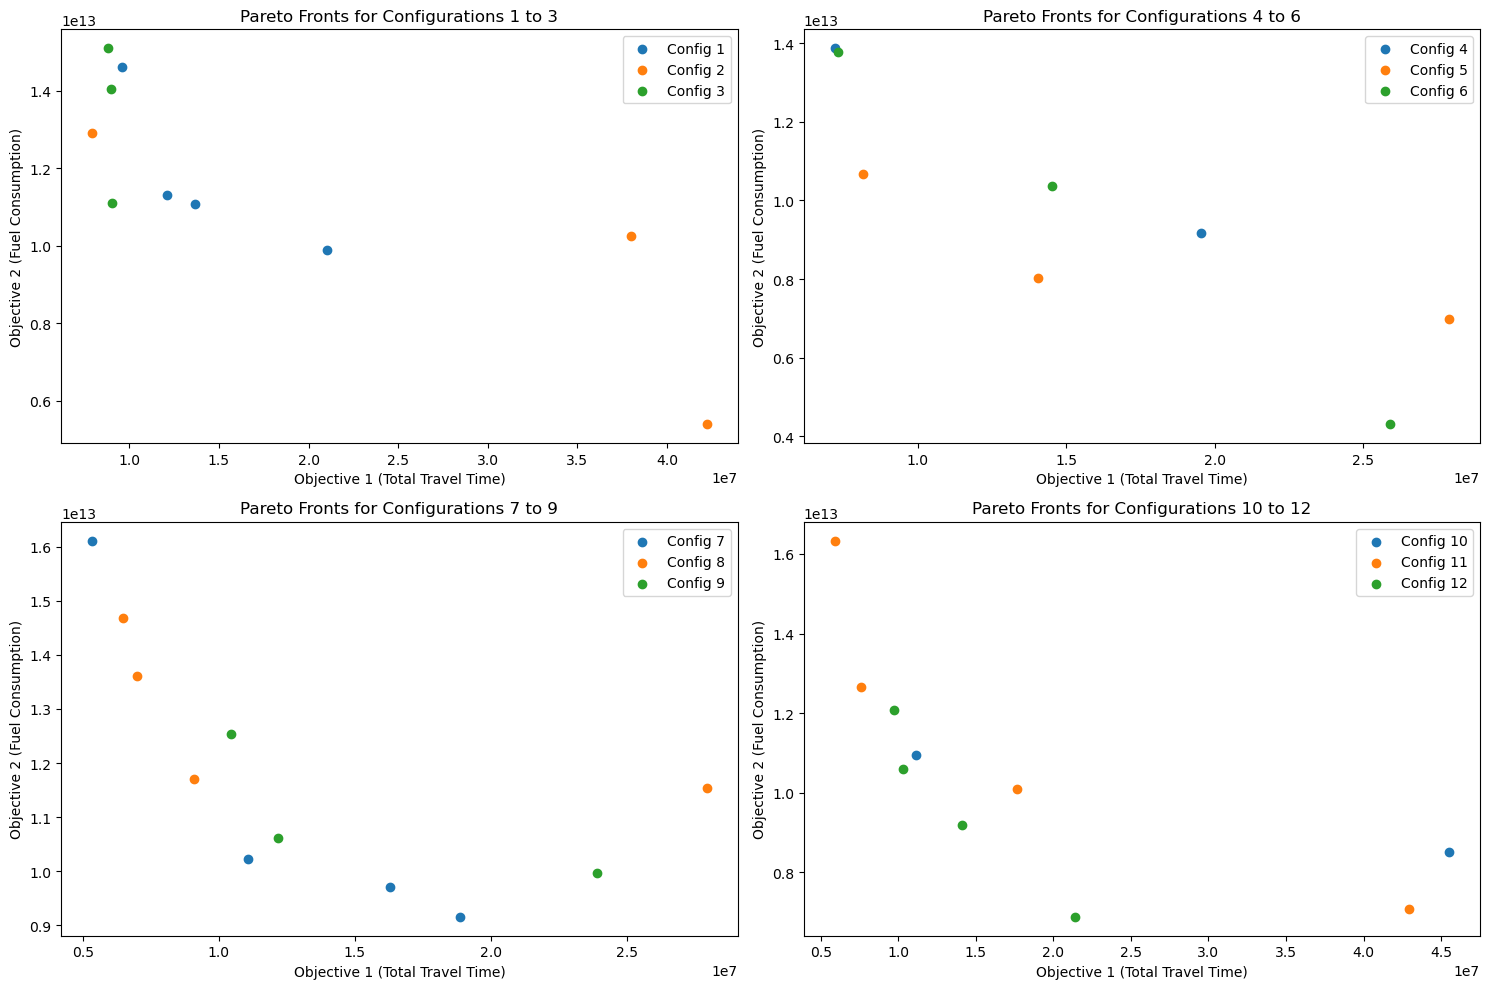

In [422]:
# Plot Pareto fronts in 4 subplots with 3 fronts each
plot_pareto_fronts_in_subplots(pareto_fronts, configs)

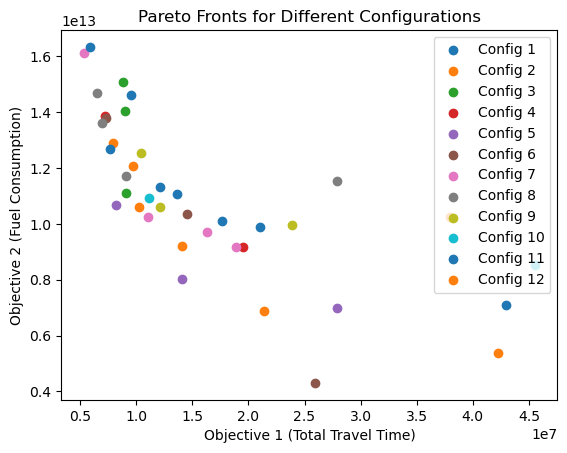

In [423]:
# Plot all results of Pareto fronts for each configuration
plot_pareto_fronts(pareto_fronts, configs)

## OLD CODE
- For referance and discussion

In [424]:
# # Custom mutation function for MOEA
# def custom_mutation(individual, mu, sigma, indpb):
#     # print(f"\nStarting mutation for individual: {individual}")  # Debug

#     green, yellow, red = individual[0], individual[1], individual[2]

#     # Mutate green light timing and clamp
#     if np.random.rand() < indpb:
#         mutated_value = green + np.random.normal(mu, sigma)
#         green = int(max(MIN_GREEN, min(mutated_value, MAX_GREEN)))
#         # print(f"Traffic light mutation (green): Previous: {individual[0]}, Mutated: {green}")  # Debug

#     # Mutate yellow light timing and clamp
#     if np.random.rand() < indpb:
#         mutated_value = yellow + np.random.normal(mu, sigma)
#         yellow = int(max(MIN_YELLOW, min(mutated_value, MAX_YELLOW)))
#         # print(f"Traffic light mutation (yellow): Previous: {individual[1]}, Mutated: {yellow}") # Debug

#     # Mutate red light timing and clamp
#     if np.random.rand() < indpb:
#         mutated_value = red + np.random.normal(mu, sigma)
#         red = int(max(MIN_RED, min(mutated_value, MAX_RED)))
#         # print(f"Traffic light mutation (red): Previous: {individual[2]}, Mutated: {red}") # Debug

#     # Enforce the cycle time constraint
#     cycle_time = green + yellow + red
#     if cycle_time < MIN_CYCLE_TIME or cycle_time > MAX_CYCLE_TIME:
#         if cycle_time > MAX_CYCLE_TIME:
#             scaling_factor = MAX_CYCLE_TIME / cycle_time
#             green = max(MIN_GREEN, int(green * scaling_factor))
#             yellow = max(MIN_YELLOW, int(yellow * scaling_factor))
#             red = max(MIN_RED, int(red * scaling_factor))
            
#         elif cycle_time < MIN_CYCLE_TIME:
#             scaling_factor = MIN_CYCLE_TIME / cycle_time
#             green = min(MAX_GREEN, max(MIN_GREEN, int(green * scaling_factor)))
#             yellow = min(MAX_YELLOW, max(MIN_YELLOW, int(yellow * scaling_factor)))
#             red = min(MAX_RED, max(MIN_RED, int(red * scaling_factor)))

#     # Ensure positivity and enforce final bounds
#     green = int(max(MIN_GREEN, min(green, MAX_GREEN)))
#     yellow = int(max(MIN_YELLOW, min(yellow, MAX_YELLOW)))
#     red = int(max(MIN_RED, min(red, MAX_RED)))

#     # Apply the adjusted integer values back to the individual
#     individual[0], individual[1], individual[2] = green, yellow, red

#     # Mutate speed limits for the remaining segments
#     for i in range(3, len(individual)):
#         if np.random.rand() < indpb:
#             # Apply mutation with Gaussian noise, round, and then clamp to enforce constraints
#             mutated_speed = int(round(individual[i] + np.random.normal(mu, sigma)))
            
#             # Ensure the mutated speed is within min and max limits
#             new_speed = int(max(MIN_SPEED, min(mutated_speed, MAX_SPEED)))
            
#             # Debug for negative values
#             if new_speed < MIN_SPEED:
#                 print("Error: Speed limit became negative after mutation.")
#                 new_speed = MIN_SPEED  # Set to minimum allowed

#             # Debugging print to verify mutation step-by-step
#             # if new_speed != individual[i]:
#             #     print(f"Speed limit mutation: Previous: {individual[i]}, Mutated: {new_speed}")

#             # Update the individual with the clamped, integer speed limit
#             individual[i] = new_speed
#     return (individual,)